In [0]:
import numpy as np

import matplotlib.pyplot as plt
import heapq
from functools import partial
from random import expovariate

In [0]:
class LIF_neuron(object):
  '''leaky Integrated-and-fire model given- 
      
     reset_potential (float)
     resting_potential (float)
     firing_threshold (float)
     refeactory_time (float)
     membrane_time_constant (float)
     
     membrane_resistance (float)
     
     membrane_potential (array)
     
     spike_delta (float)
     last_spike (int)
     
     current_time (int)
     
     synaptic_strength (float)
     
     neuronal_output (float)
     neuronal_input (float)
     
     effective_dendrites (array)
     effective_synapses (array)
     
     update_state (int)
     update_time  (int)
     synaptic_delay (float)
     
     dt (float)
      
    '''
  
  PENDING=1
  UPDATE_QUEUED=2
      
  def __init__(self, Rm=10., 
                 Vreset=-65., Vrest=-70.,
                theta=-50.,tau_ref=2,tau_m=8,
                total_time=20000, current_time=0,
                J=0.1, neuron_type=1, network=None,
                synaptic_delay=1.5, dt=0.02):
      
     
      #self.seed = np.random.seed(1)
      
      self.resert_potential=float(Vreset)#+np.random.randint(-10, +10)
      self.resting_potential=float(Vrest)#+np.random.randint(0, 15)
      self.firing_threshold=float(theta)#+np.random.randint(-5, +5)
      self.refeactory_time=float(tau_ref)#+np.random.randint(-1, 1)
      self.membrane_time_constant=tau_m
      
      self.membrane_resistance=float(Rm)#+np.random.randint(-1, 1) 
      self.dt=dt

      
      self.membrane_potential=[self.resting_potential,self.resting_potential]
      self.spike_delta=1.2
      self.last_spike=0
      
      self.current_time=current_time
      
      self.synaptic_strength=float(J)
      self.neuronal_output=0.
      self.neuronal_input=0.
      self.effective_dendrites=[]
      self.effective_synapses=[]
      
      self.type=neuron_type  
      self.network=network
      
      self.update_state=self.PENDING
      self.update_time=0
      self.synaptic_delay=synaptic_delay
      
    
      

    
  def dVdt(self, Vm, I):
    '''returns the instantaneous voltage change
      as a function of Cm, gl, Vrest and I
      
      dVdt = (I*Rm- (V-V_rest))/tau_m
     '''
    return (I*self.membrane_resistance-(Vm-self.resting_potential))/self.membrane_time_constant
    
  def update_membrane_potential(self,input_current):
    '''
    Using an implicit Euler method:
    f(x) = f(x-1) + dt*f'(x)
    
    to calculate the next membrane potential given stimuli
    i- time (ms) , input current -current (A)
    
    '''
    self.update_state=self.PENDING
    if input_current==None:
      raise 'Error with input'
      
    

    i=int(self.current_time%2)
    #print (i, self.current_time, input_current)
    if self.current_time>self.last_spike+self.refeactory_time:
      
      dVdt=self.dVdt(Vm=self.membrane_potential[i-1], I=input_current)
      self.membrane_potential[i] = self.membrane_potential[i-1] + dVdt*self.membrane_time_constant/1000 #(s)
      #print (self.membrane_potential[i])
      #print()
    # action potential threshold
      if self.membrane_potential[i]>=self.firing_threshold: 
        self.membrane_potential[i]=self.resert_potential # reset voltage
        self.membrane_potential[i-1]=self.resting_potential+self.spike_delta # overshooting
        self.last_spike=self.current_time


    else:
      self.membrane_potential[i]=self.resert_potential

  
  def update(self):
    '''
     notify fire dendrites
    '''   
    self.update_membrane_potential(self.neuronal_input)
    if len(self.effective_dendrites)>0:
      self.trigger_suceeding_neurons()
    
    
  def input_notification(self, preceding_neuron_output):
    '''
    updates the neuron that new input has arrived
    '''
    ### add input
    if self.update_time!=round(self.current_time/self.dt): #step
      self.neuronal_input=preceding_neuron_output
      self.update_time=round(self.current_time/self.dt) #step
    else:
      self.neuronal_input+=preceding_neuron_output
    
    ## check state
    if self.update_state==self.PENDING:
      
      # if pending add an update to the queue and change state
      event_to_push = (self.current_time+self.synaptic_delay,
                       self.network.event_counter,self.update)
      heapq.heappush(self.network.queue, event_to_push)
      self.network.event_counter+=1
      self.update_state=self.UPDATE_QUEUED
      
  
  def trigger_suceeding_neurons(self):
    '''
    calcs updated output current
    notfies all suceeding neurons
    '''
    self.neuronal_output=int(self.spike_delta*self.synaptic_strength)
    for neuron in self.effective_dendrites:
      neuron.input_notification(self.neuronal_output)
    


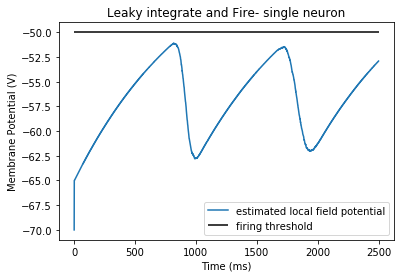

In [0]:
trials = 1000
VV=[]
for i in range(trials):
  mycell = LIF_neuron()
  T=int(50/0.02)
  V=[]
  for i in range(T):
    mycell.current_time = i
    mycell.update_membrane_potential(np.random.normal(3,2))

    V.append(mycell.membrane_potential[1])
  VV.append(V)
    

plt.title('Leaky integrate and Fire- single neuron')
plt.hlines(-50, 0, T, label='firing threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (V)')
plt.plot(np.linspace(0, T, T)
         ,np.mean(VV, axis = 0), label='estimated local field potential')
plt.legend()
plt.show()

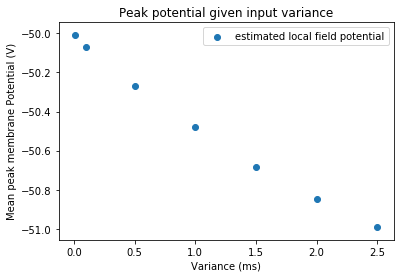

In [0]:
variances = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5]
v_peak = []
vv=[]
for var in variances:
  for i in range(trials):
    mycell = LIF_neuron()
    T=int(50/0.02)
    V=[]
    for i in range(T):
      mycell.current_time = i
      mycell.update_membrane_potential(np.random.normal(3,var))

      V.append(mycell.membrane_potential[1])
    vv.append(V)
  v_peak.append(np.max(np.mean(vv, axis = 0)))
    
plt.title('Peak potential given input variance')
plt.xlabel('Variance (ms)')
plt.ylabel('Mean peak membrane Potential (V)')
plt.scatter(variances
         ,v_peak, label='estimated local field potential')
plt.legend()
plt.show()

In [0]:
class brunel_network(object):
  '''brunel model based on Brunel (2000) 
     sparsely connected network of identical LIF neurons (Model A)
     
     connection_prob (float) epsilon- proportion of neurons each neuron 
       projects
     N_excitatory_neurons (int) Number of excitatory neurons in the network
     N_inhibitory_neurons (int) Number of inhibitory neurons in the network
     N_external_neurons (int Number of external neurons in the network
     resting_potential (int) Vrest - is the resting membrane potential, 
        can also be seen as the potential of the resistor- uniform 
        accross all neurons (V)
     resert_potential (int) Reset voltage after spike  (mV)
     N_excitatory_synapses (int) connections for excitatory neurons
     N_inhibitory_synapses (int) connections  for inhibitory neurons
     N_external_synapses (int) which are excitatory connection from outside 
       the network
     firing_threshold (float) theta- firing threshold (mV)
     synaptic_strength (float) J_e-  the excitatory postsynaptic potential 
       uniform accross all neurons (mV)  
       # w_ee = w_ei = w0 
     inhibition_importance (float) G- The relative strength of 
       inhibitory synapses. defalut value 4 - this is a balance value since
       there are 4 times excitatory synapeses than inhibitory ones
     inhibitory_strength (float) J_i the inhibitory postsynaptic potential 
       # w_ie=w_ii = -g*w0
     synaptic_delay (float) Transmission delay - the delay between presynaptic 
       spike and postsynaptic increase of v_m (ms)
     membrane_time_constant (float) The excitatory membrane time constant (ms)
     refractory_period (float) The refeactory time (ms)
     external_poisson_rate (float) Poisson rate of the external population Hz
     external_synaptic_strength (float) w_external - Synaptic weight of the 
       excitatory external inputs    
     sim_time (int) total simulation time (ms)
     cell_param (dict) all neurons are of same basic parameters     
     neuron_population (np array) the array that holds all the neurons
     external_population (array) the array that holds all the external neurons     
     current_T (float) current time of the simulation     
     queue (min-heap) an event queue
     N_monitor_subset (int) the number of random neurons to monitor
     monitor_idx (array) ids of the monitored neurons
     neural_rate_metric (array of arrays) collects firing rates of the neurons in 
       the population (i.e the times of spiking)
     population_spike_metric (array) the number of spiking neurons in 
       the population [Hz]
     population_voltage_metric (array) collects the population's voltage [mV]
     
     event_counter (int)
  '''
  EXCITATORY=1
  INHIBITORY=2
  EXTERNAL=3
  
  def __init__(self, sim_time=20., inhibition_importance=4., 
               external_poisson_rate=13, N_excitatory_neurons=300, g=.1):

    self.dt=0.02

    self.connection_prob=0.1
    self.N_excitatory_neurons=N_excitatory_neurons
    self.N_inhibitory_neurons=int(self.N_excitatory_neurons/4.)
    self.N_external_neurons=int(self.N_excitatory_neurons/5.)
    self.resting_potential=-70.
    self.resert_potential=-65.  
    self.N_excitatory_synapses=int(self.connection_prob*\
                       self.N_excitatory_neurons)
    self.N_inhibitory_synapses=int(self.connection_prob*\
                       self.N_inhibitory_neurons)
    self.N_external_synapses=int(self.N_excitatory_synapses)
    self.firing_threshold=-50.
    self.synaptic_strength=0.1#J #W0 mV
    self.inhibition_importance=float(inhibition_importance)
    self.inhibitory_strength=-self.inhibition_importance*\
                       self.synaptic_strength
    self.synaptic_delay=1.5
    self.membrane_time_constant=8. # dt in neuron lvl
    self.refractory_period=2.
    self.external_poisson_rate=external_poisson_rate/1000.
    self.external_synaptic_strength=self.synaptic_strength
    self.sim_time=int(sim_time)
    self.sim_steps=int(sim_time/self.dt) #ms
    self.neuron_population=np.empty(self.N_excitatory_neurons+
                                            self.N_inhibitory_neurons, 
                                    dtype=object)
    self.external_population=[]
    
    self.current_timestep=0
    self.queue=[] ## (time, func)
    heapq.heapify(self.queue)
    self.N_monitor_subset=min(100,N_excitatory_neurons)
    self.monitor_idx=np.random.choice(range(self.N_excitatory_neurons+
                                            self.N_inhibitory_neurons),
                                       self.N_monitor_subset,
                                      replace=False)
    self.neural_rate_metric=[]
    self.population_spike_metric=[]
    self.population_voltage_metric=[]
    
    self.event_counter=0
    


  def initiate_network(self):
    '''
    1. cerate all neurons 
    2. create all synapses and dendrites (inner and outer connections
       to the population)
    ''' 
    ## add neurons
    for i in range(self.N_excitatory_neurons):
      excit_neuron_params = {'Rm':10., 
                             'Vreset':self.resert_potential,
                             'Vrest':self.resting_potential,
                             'theta':self.firing_threshold,
                             'tau_ref':self.refractory_period,
                             'tau_m':self.membrane_time_constant,
                             'total_time':self.sim_time, 
                             'current_time':0,
                             'J':self.synaptic_strength, 
                             'neuron_type':self.EXCITATORY, 
                             'network':self,
                             'synaptic_delay':self.synaptic_delay,
                             'dt':self.dt}
      self.neuron_population[i]=LIF_neuron(**excit_neuron_params)


    for i in range(self.N_inhibitory_neurons): 
      inhibit_neuron_params = {'Rm':10., 
                             'Vreset':self.resert_potential,
                             'Vrest':self.resting_potential,
                             'theta':self.firing_threshold,
                             'tau_ref':self.refractory_period,
                             'tau_m':self.membrane_time_constant,
                             'total_time':self.sim_time, 
                             'current_time':0,
                             'J':self.inhibitory_strength, 
                             'neuron_type':self.INHIBITORY, 
                             'network':self,
                             'synaptic_delay':self.synaptic_delay,
                             'dt':self.dt}
      self.neuron_population[i+self.N_excitatory_neurons]=\
                                 LIF_neuron(**inhibit_neuron_params)

    for i in range(self.N_external_neurons):
      external_excit_neuron_params = {'Rm':10., 
                             'Vreset':self.resert_potential,
                             'Vrest':self.resting_potential,
                             'theta':self.firing_threshold,
                             'tau_ref':self.refractory_period,
                             'tau_m':self.membrane_time_constant,
                             'total_time':self.sim_time, 
                             'current_time':0,
                             'J':self.synaptic_strength, 
                             'neuron_type':self.EXTERNAL, 
                             'network':self,
                             'synaptic_delay':0,
                             'dt':self.dt}

      self.external_population.append(LIF_neuron
                                      (**external_excit_neuron_params))




    # add connections
    exitatory_population=self.neuron_population[:self.N_excitatory_neurons]
    inhibitory_population=self.neuron_population[self.N_excitatory_neurons:]
    ### deffective_endrites
    
    
    for neuron_i in self.neuron_population:
       
      external_synapses=np.random.choice(self.external_population, 
                                          size=self.N_external_synapses,
                                          replace=False)
        
      excitatory_synapses=np.random.choice(exitatory_population, 
                                          size=self.N_excitatory_synapses,
                                          replace=False)
        
      inhibitory_synapses=np.random.choice(inhibitory_population, 
                                          size=self.N_inhibitory_synapses,
                                         replace=False)
        
      synapses= np.concatenate((inhibitory_synapses, 
                                excitatory_synapses,
                                external_synapses), axis=0)
                                   
      
      neuron_i.effective_synapses=synapses
      
      for neuron in synapses:
        neuron.effective_dendrites.append(neuron_i)
    
      
      
  def schedule_external_input(self):
    '''
    follows an independent Poisson process to generate timesteps for
    external stimuli given the rate defined

    '''

    t=0
    
    while t<self.sim_time:
      t+= random.expovariate(self.external_poisson_rate)
      for ext_neuron in self.external_population:
        event_tuple = (t, self.event_counter,
                       ext_neuron.trigger_suceeding_neurons)
        heapq.heappush(self.queue, event_tuple)
        self.event_counter+=1
      
      
    
      
  def collect_metrics(self):
    '''
    collects the three metrics of the randomly 
    chosen subset of the population
    '''
    monitored_subset = self.neuron_population[self.monitor_idx]

    voltage = [neuron.membrane_potential[1] for neuron in monitored_subset]
    self.population_voltage_metric.append(voltage)
    
    rate=np.array(voltage)>=(self.firing_threshold-.05)

    self.neural_rate_metric.append(rate)
    self.population_spike_metric.append(sum(voltage))

  def schedule_metric_collection(self):
    '''
    collects metric at the end of each time step
    '''
    for time_step in range(self.sim_steps):
        event_tuple = (time_step, np.inf, self.collect_metrics)
        heapq.heappush(self.queue, event_tuple)
        #self.event_counter+=1
    
  def plot_voltage (self):
    
      # V(t)
      
      plt.title('Voltage traces plot')
      for neuron in np.array(self.population_voltage_metric).T[:2]:
        plt.plot(neuron)
      
      plt.xticks(np.arange(0, self.sim_steps, step=50),
                 np.arange(0, self.sim_time, step=1))
      plt.xlabel('t [ms]')
      plt.ylabel('V(t) [Mv]')
      plt.show()
      
  def plot_activity (self):     
      #A(t)
      
      plt.title('Population activity plot')
      plt.plot(self.population_spike_metric)
      plt.xticks(np.arange(0, self.sim_steps, step=50),
                 np.arange(0, self.sim_time, step=1))
      plt.xlabel('t [ms]')
      plt.ylabel('A(t) [Hz]')
      plt.show()

  def plot_raster (self):
      # raster
      L=len(np.array(self.population_voltage_metric).T[0]/50)
      
      plt.title('Raster plot')
      for i,neuron in enumerate(np.array(self.population_voltage_metric).T):
          plt.scatter([j for j in range(L)]*(neuron>=-51), [i]*L, marker='.', 
                      c='teal',s=4)
      

      plt.xticks(np.arange(0, self.sim_steps, step=50),
                 np.arange(0, self.sim_time, step=1))
      plt.xlabel('t [ms]')
      plt.ylabel('Neuron #')
      plt.show()



    
  def run(self, verbrose=False):
    '''
    The main simulation function. It manages an asyncronous queue
    that handles the neural updating, and metric collection.
    '''
    self.schedule_external_input()
    self.schedule_metric_collection()
    prev_time = 0
    while True:
      if len(self.queue)==0:
        break
      current_event=heapq.heappop(self.queue)
      # update time
      
      self.current_timestep=current_event[0]
      for neuron in self.neuron_population:
        neuron.current_time=self.current_timestep
        
 
      if verbrose:
        if int(self.current_timestep)%100==0:
          print(self.current_timestep)
      # execute current event
      current_event[2]()
      if self.current_timestep>=self.sim_steps:
        break
        
      
        

#n=brunel_network()

In [0]:
N_neurons=1000
time=40

# sync 40/2000, g=.2

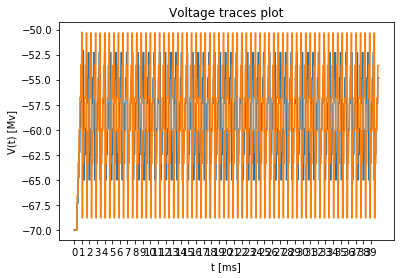

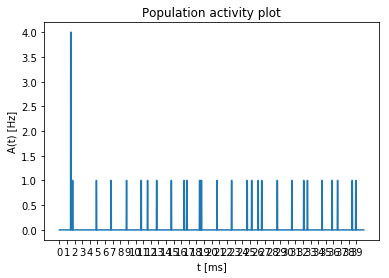

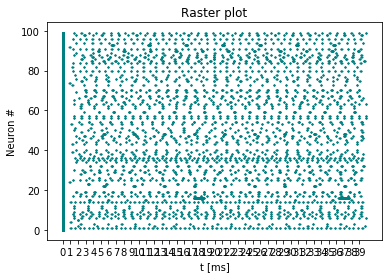

In [0]:
params7={'sim_time':time, 'inhibition_importance':2.5, 
               'external_poisson_rate':14, 'N_excitatory_neurons':2000, 
         'g':.2}

n7=brunel_network(**params7)
n7.initiate_network()
n7.run()

n7.plot_voltage()
n7.plot_activity()
n7.plot_raster()


# Async 40/2000, g=.2

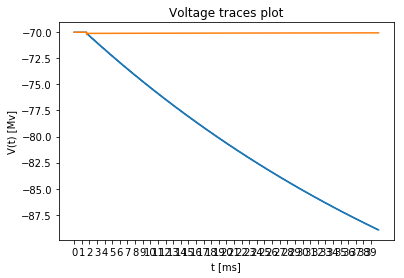

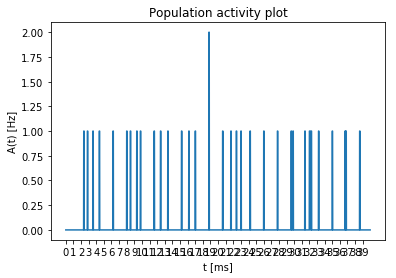

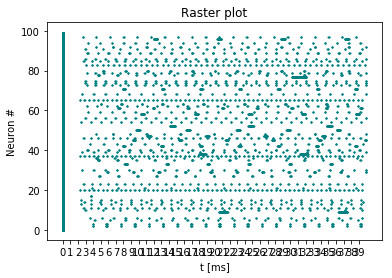

In [0]:
params8={'sim_time':time, 'inhibition_importance':4, 
               'external_poisson_rate':12, 'N_excitatory_neurons':2000, 
         'g':.2}

n8=brunel_network(**params8)
n8.initiate_network()
n8.run()

n8.plot_voltage()
n8.plot_activity()
n8.plot_raster()


# sync 40/1000, g=.5

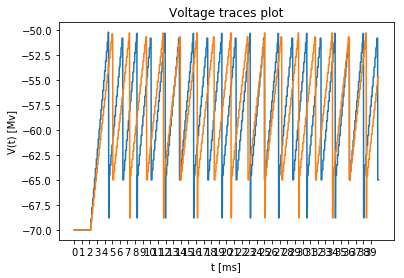

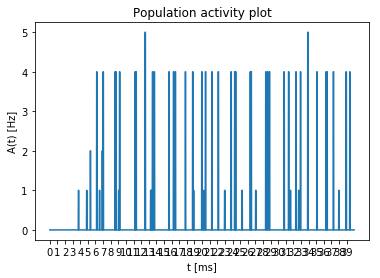

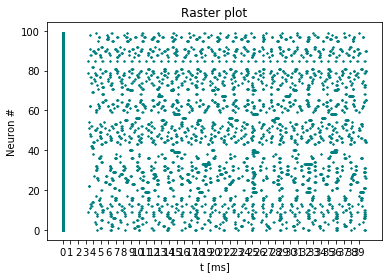

In [0]:
params5={'sim_time':time, 'inhibition_importance':2.5, 
               'external_poisson_rate':14, 'N_excitatory_neurons':N_neurons, 
         'g':.5}

n5=brunel_network(**params5)
n5.initiate_network()
n5.run()

n5.plot_voltage()
n5.plot_activity()
n5.plot_raster()


In [0]:
#np.mean(arr.reshape(-1, 3), axis=1)

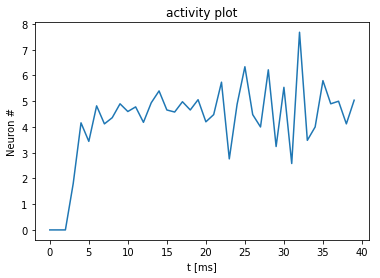

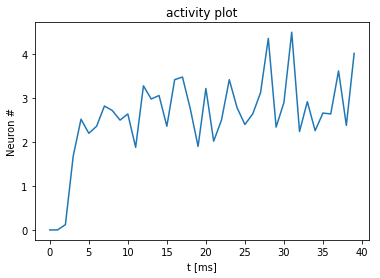

In [0]:
def plot_field(n, size):
    # raster
    L=size#len(np.array(n.population_voltage_metric).T[0]/50)

    plt.title('activity plot')
    step_activity_summed = []
    for i,neuron in enumerate(np.array(n.population_voltage_metric)):
      step_activity_summed.append(sum(neuron>=-51))
    
    plott = np.mean(np.array(step_activity_summed).reshape(-1, 50), axis=1)
    plt.plot(plott)

    plt.xlabel('t [ms]')
    plt.ylabel('Neuron #')
    plt.show()


def plot_raster (n, size):
    # raster
    L=size#len(np.array(n.population_voltage_metric).T[0]/50)

    plt.title('Raster plot')
    for i,neuron in enumerate(np.array(n.population_voltage_metric).T):
      if i in [24,62,98,43]:
        plt.scatter([j for j in range(L)]*(neuron>=-51)[:size], [i]*L, marker='.', 
                    c='coral',s=30)
      else:
        plt.scatter([j for j in range(L)]*(neuron>=-51)[:size], [i]*L, marker='.', 
                    c='teal',s=4)
        


    plt.xlabel('t [ms]')
    plt.ylabel('Neuron #')
    plt.show()

plot_field(n5, 500)
plot_field(n6, 500)
#plot_raster(n5, 300)
#plot_raster(n6, 300)

# sync 40/1000, g=0.5

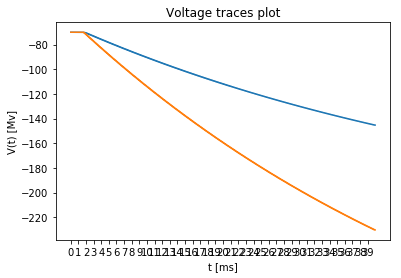

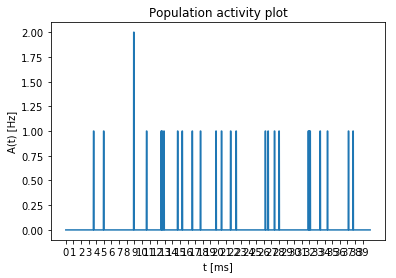

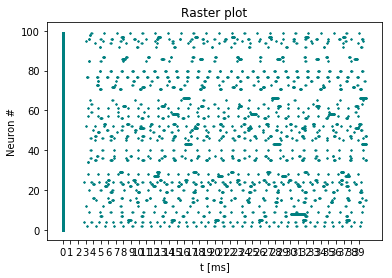

In [0]:
params6={'sim_time':time, 'inhibition_importance':4, 
               'external_poisson_rate':12, 'N_excitatory_neurons':N_neurons, 
         'g':.5}

n6=brunel_network(**params6)
n6.initiate_network()
n6.run()

n6.plot_voltage()
n6.plot_activity()
n6.plot_raster()


# sync 40/1000, g=1

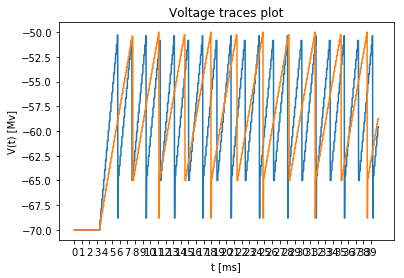

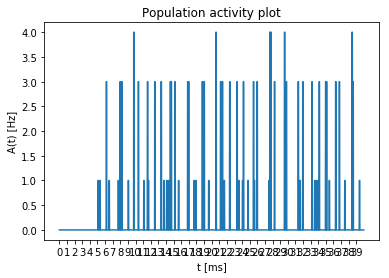

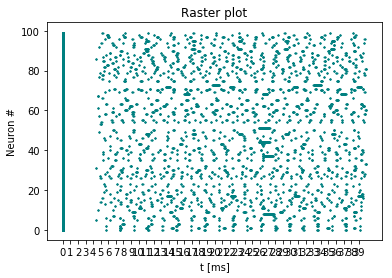

In [0]:
params3={'sim_time':time, 'inhibition_importance':2.5, 
               'external_poisson_rate':14, 'N_excitatory_neurons':N_neurons, 
         'g':1}

n3=brunel_network(**params3)
n3.initiate_network()
n3.run()

n3.plot_voltage()
n3.plot_activity()
n3.plot_raster()


# async 40/1000, g=1

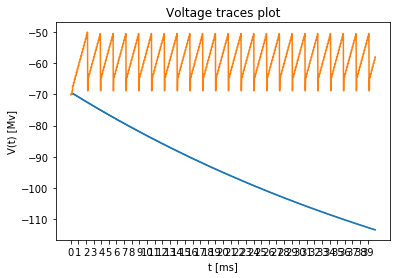

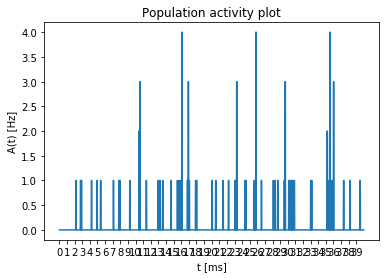

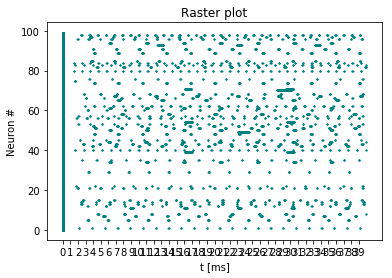

In [0]:
params4={'sim_time':time, 'inhibition_importance':4, 
               'external_poisson_rate':12, 'N_excitatory_neurons':N_neurons, 
         'g':1}

n4=brunel_network(**params4)
n4.initiate_network()
n4.run()

n4.plot_voltage()
n4.plot_activity()
n4.plot_raster()


# sync 40/1000, g=2

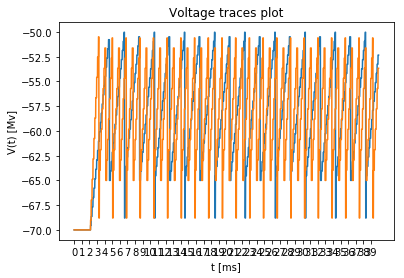

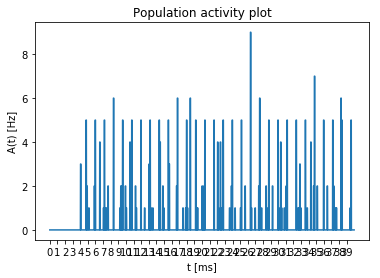

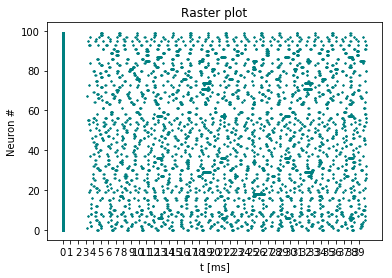

In [0]:
params1={'sim_time':time, 'inhibition_importance':2.5, 
               'external_poisson_rate':14, 'N_excitatory_neurons':N_neurons,
         'g':2}

n1=brunel_network(**params1)
n1.initiate_network()
n1.run()

n1.plot_voltage()
n1.plot_activity()
n1.plot_raster()


# async  40/1000, g=2

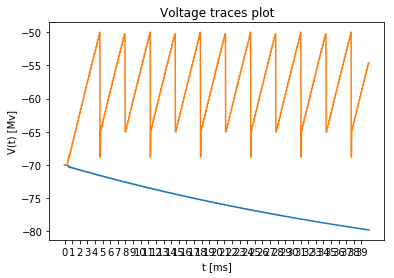

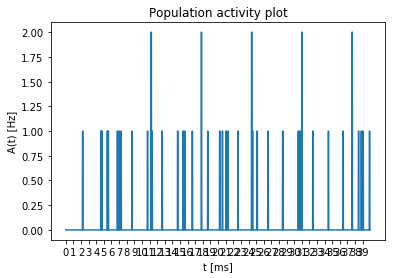

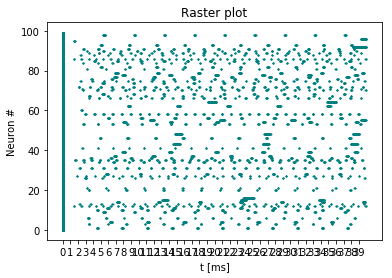

In [0]:
params2 = {'sim_time':time, 'inhibition_importance':4., 
               'external_poisson_rate':12., 'N_excitatory_neurons':N_neurons, 
           'g':2}

n2=brunel_network(**params2)
n2.initiate_network()
n2.run()


n2.plot_voltage()
n2.plot_activity()
1n2.plot_raster()